In [271]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
import graphviz


from sklearn import set_config
set_config(transform_output="pandas")

In [272]:
# read data
df_regular = pd.read_csv("2021-2022 NBA Player Stats - Regular.csv",encoding='latin-1', delimiter=";")
df_playoffs = pd.read_csv("2021-2022 NBA Player Stats - Playoffs.csv",encoding='latin-1', delimiter=";")

In [273]:

# rename columns for better interpretability.  Took directly from kaggle dataset page.

def rename_columns(df):
    df.rename(columns={'Rk' : 'Rank', 'Player' : 'Players_name', 'Pos' : 'Position', 'Age' : 'Players_age', 'Tm' : 'Team', 'G' : 'Games_played', 'GS' : 'Games_started', 'MP' : 'Minutes_played_per_game', 'FG' : 'Field_goals_per_game', 'FGA' : 'Field_goal_attempts_per_game', 'FG%' : 'Field_goal_percentage', '3P' : '3_point_field_goals_per_game', '3PA' : '3_point_field_goal_attempts_per_game', '3P%' : '3_point_field_goal_percentage', '2P' : '2_point_field_goals_per_game', '2PA' : '2_point_field_goal_attempts_per_game', '2P%' : '2_point_field_goal_percentage', 'eFG%' : 'Effective_field_goal_percentage', 'FT' : 'Free_throws_per_game', 'FTA' : 'Free_throw_attempts_per_game', 'FT%' : 'Free_throw_percentage', 'ORB' : 'Offensive_rebounds_per_game', 'DRB' : 'Defensive_rebounds_per_game', 'TRB' : 'Total_rebounds_per_game', 'AST' : 'Assists_per_game', 'STL' : 'Steals_per_game', 'BLK' : 'Blocks_per_game', 'TOV' : 'Turnovers_per_game', 'PF' : 'Personal_fouls_per_game', 'PTS' : 'Points_per_game'}, inplace=True)
    return df

df_regular = rename_columns(df_regular)
df_playoffs = rename_columns(df_playoffs)

In [274]:
# convert position column to only have guard, forward, and center (3 classes)

def convert_position(df):
    df['Class'] = df['Position'].map({'SG': 'Guard','SF' : 'Forward', 'PG' : 'Guard', 'PF' : 'Forward', 'C' : 'Center','SG-SF' : 'Guard', 'SF-SG' : 'Forward', 'SG-PG' : 'Guard', 'C-PF' : 'Center', 'PF-SF' : 'Forward', 'PG-SG' : 'Guard'})
    df.drop(columns=['Position'], inplace=True)
    return df

df_regular = convert_position(df_regular)
df_playoffs = convert_position(df_playoffs)


In [275]:
# remove players who played less than 2 games since their statistics are not significant

df_regular = df_regular[~df_regular.Games_played < 2]
df_playoffs = df_playoffs[~df_playoffs.Games_played < 2]

In [276]:
# encode class column as numeric using LabelEncoder

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_regular['Class'] = le.fit_transform(df_regular['Class'])
df_playoffs['Class'] = le.fit_transform(df_playoffs['Class'])

In [277]:
df_regular['3_point_vs_2_point_attempts'] = (df_regular['3_point_field_goal_attempts_per_game'] * df_regular['Games_played'] + 1).div(df_regular['2_point_field_goal_attempts_per_game'].values * df_regular['Games_played'] + 1)

# sum the three scaled columns to create a new column called 'Defensive_stats'

df_regular['Defensive_stats'] = df_regular['Defensive_rebounds_per_game'] + df_regular['Steals_per_game'] + df_regular['Blocks_per_game'] + .01

# get the percentage of the three scaled columns relative to the sum of the three scaled columns

df_regular['Defensive_rebounds_per_game_percentage'] = df_regular['Defensive_rebounds_per_game'].div(df_regular['Defensive_stats'])
df_regular['Steals_per_game_percentage'] = df_regular['Steals_per_game'].div(df_regular['Defensive_stats'])
df_regular['Blocks_per_game_percentage'] = df_regular['Blocks_per_game'].div(df_regular['Defensive_stats'])
# repeat the same process for the following columns Assists, Offensive_Rebounds,Turnovers, 3_point_field_goals

df_regular['Offensive_stats'] = df_regular['Assists_per_game'] + df_regular['Offensive_rebounds_per_game'] + df_regular['Turnovers_per_game'] + df_regular['3_point_field_goals_per_game'] + .01

# get the percentage of the four scaled columns relative to the sum of the four scaled columns

df_regular['Assists_per_game_percentage'] = df_regular['Assists_per_game'].div(df_regular['Offensive_stats'])
df_regular['Offensive_rebounds_per_game_percentage'] = df_regular['Offensive_rebounds_per_game'].div(df_regular['Offensive_stats'])
df_regular['Turnovers_per_game_percentage'] = df_regular['Turnovers_per_game'].div(df_regular['Offensive_stats'])
df_regular['3_point_field_goals_per_game_percentage'] = df_regular['3_point_field_goals_per_game'].div(df_regular['Offensive_stats'])


In [278]:
# print the extra features created above



In [279]:
df_playoffs['3_point_vs_2_point_attempts'] = (df_playoffs['3_point_field_goal_attempts_per_game'] * df_playoffs['Games_played'] + 1).div(df_playoffs['2_point_field_goal_attempts_per_game'].values * df_playoffs['Games_played'] + 1)

# sum the three scaled columns to create a new column called 'Defensive_stats'

df_playoffs['Defensive_stats'] = df_playoffs['Defensive_rebounds_per_game'] + df_playoffs['Steals_per_game'] + df_playoffs['Blocks_per_game'] + .01

# get the percentage of the three scaled columns relative to the sum of the three scaled columns

df_playoffs['Defensive_rebounds_per_game_percentage'] = df_playoffs['Defensive_rebounds_per_game'].div(df_playoffs['Defensive_stats'])
df_playoffs['Steals_per_game_percentage'] = df_playoffs['Steals_per_game'].div(df_playoffs['Defensive_stats'])
df_playoffs['Blocks_per_game_percentage'] = df_playoffs['Blocks_per_game'].div(df_playoffs['Defensive_stats'])
# repeat the same process for the following columns Assists, Offensive_Rebounds,Turnovers, 3_point_field_goals

df_playoffs['Offensive_stats'] = df_playoffs['Assists_per_game'] + df_playoffs['Offensive_rebounds_per_game'] + df_playoffs['Turnovers_per_game'] + df_playoffs['3_point_field_goals_per_game'] + .01

# get the percentage of the four scaled columns relative to the sum of the four scaled columns

df_playoffs['Assists_per_game_percentage'] = df_playoffs['Assists_per_game'].div(df_playoffs['Offensive_stats'])
df_playoffs['Offensive_rebounds_per_game_percentage'] = df_playoffs['Offensive_rebounds_per_game'].div(df_playoffs['Offensive_stats'])
df_playoffs['Turnovers_per_game_percentage'] = df_playoffs['Turnovers_per_game'].div(df_playoffs['Offensive_stats'])
df_playoffs['3_point_field_goals_per_game_percentage'] = df_playoffs['3_point_field_goals_per_game'].div(df_playoffs['Offensive_stats'])

In [280]:
# split data into train and test

from sklearn.model_selection import train_test_split

X = df_regular.drop(columns=['Class'])
y = df_regular['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# separate categorical columns from numeric
passthrough = ['Players_name', 'Team']
id_train = X_train[passthrough]
id_test = X_test[passthrough]
X_train.drop(columns=passthrough, inplace=True)
X_test.drop(columns=passthrough, inplace=True)
mask = X_train.dtypes == 'object'
categorical = X_train.columns[mask]
numeric = X_train.columns[~mask]

print('There are {} numeric columns and {} categorical columns'.format(len(numeric), len(categorical)))

There are 37 numeric columns and 0 categorical columns


In [281]:
X_playoffs = df_playoffs.drop(columns=['Class'])
y_playoffs = df_playoffs['Class']

X_id_playoffs = X_playoffs[passthrough]
X_playoffs.drop(columns=passthrough, inplace=True)

In [282]:
# create a decision tree classifier as a baseline model

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
baseline_accuracy = dt.score(X_test, y_test)

y_pred = dt.predict(X_test)
baseline_roc = roc_auc_score(y_test, dt.predict_proba(X_test), multi_class='ovr')

print('Baseline accuracy: {:.2f}'.format(baseline_accuracy))
print('Baseline ROC AUC: {:.2f}'.format(baseline_roc))


Baseline accuracy: 0.60
Baseline ROC AUC: 0.69


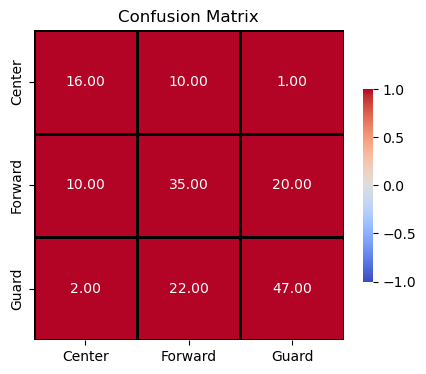

In [283]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

# add labels to the confusion matrix for Center, Forward, Guard

cm = pd.DataFrame(cm, index=le.classes_,columns=le.classes_)

# plot the confusion matrix using seaborn

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f', linewidths=1, linecolor='black', square=True, cbar_kws={'shrink': 0.5}, xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix')
plt.show()

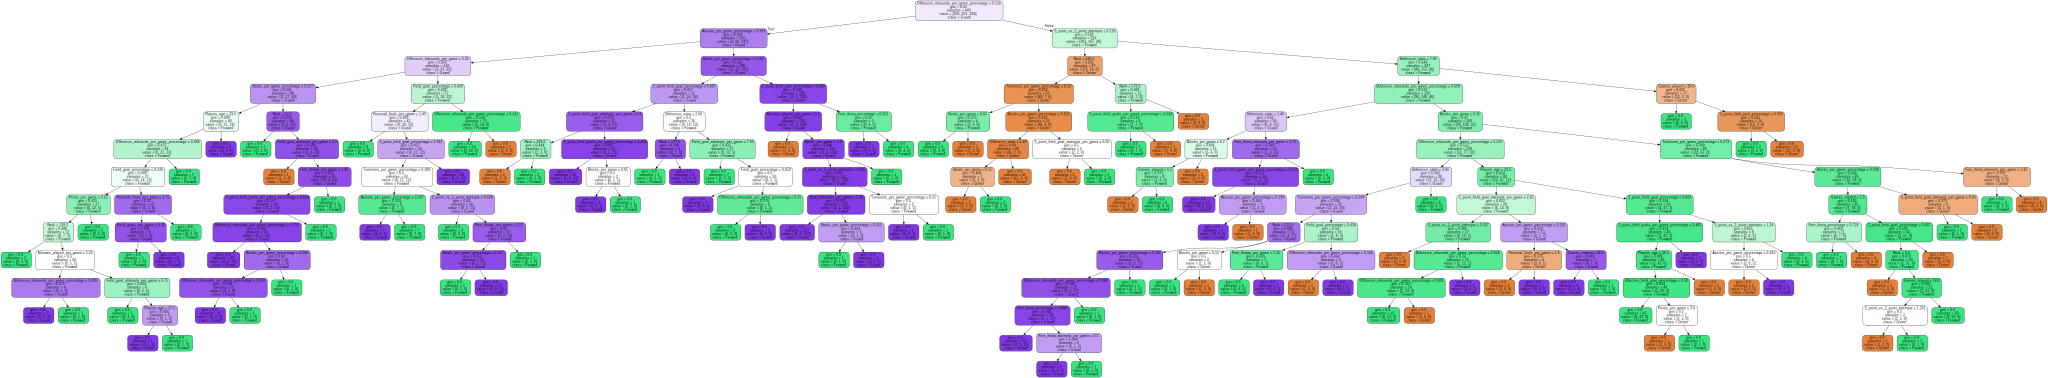

In [284]:
# plot the decision tree

from sklearn.tree import export_graphviz
import graphviz

# plot the first three levels of the decision tree
dot_data = export_graphviz(dt, out_file=None, feature_names=X_train.columns, class_names=le.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [285]:
# run a grid search to find the best parameters for the decision tree classifier

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=0)
lr_grid.fit(X_train, y_train)

lr_accuracy = lr_grid.score(X_test, y_test)
lr_auc = roc_auc_score(y_test, grid.predict_proba(X_test), multi_class='ovr')

/home/vpittamp/ls/envs/cs109a_finalproj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vpittamp/ls/envs/cs109a_finalproj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 3_point_field_goals_per_game_percentage
- 3_point_vs_2_point_attempts
- Assists_per_game_percentage
- Blocks_per_game_percentage
- Defensive_rebounds_per_game_percentage
- ...


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

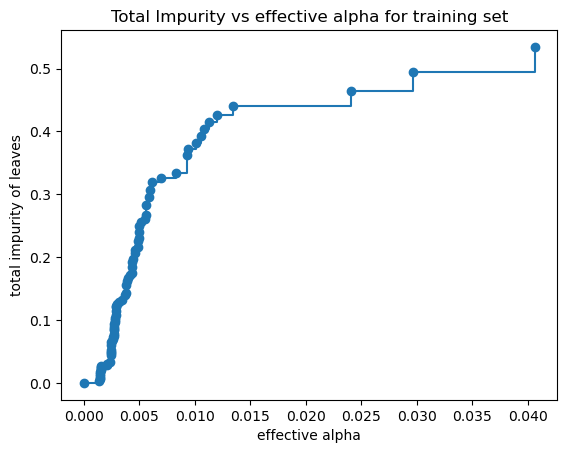

In [ ]:
# use cost complexity pruning to find the best alpha value using only a subset of parameters

path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
# use grid search to find the best alpha value of ccp_alpha, max_depth, and leaf nodes based on auc score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

params = {'ccp_alpha': ccp_alphas, 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid = GridSearchCV(dt, params, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


{'ccp_alpha': 0.005881517156388192, 'max_depth': 6, 'min_samples_leaf': 7}
0.6825163983303518


In [ ]:
# find the corresponding nodes

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.13086429549461653


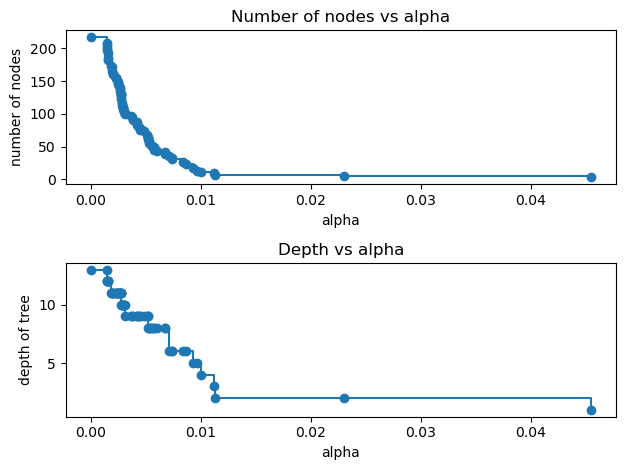

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

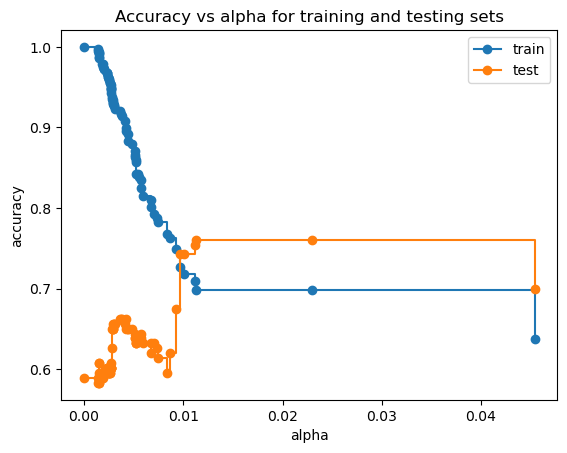

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# get index for best ccp alpha

index = np.argmax(test_scores)
best_ccp_alpha = ccp_alphas[index]
best_ccp_alpha

# create a new decision tree classifier with best ccp alpha

clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
dt_accuracy = clf.score(X_test, y_test)
dt_auc =  roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

In [ ]:
dt_accuracy, dt_auc

(0.7423312883435583, 0.8471833483848455)

In [ ]:
# get most important features for decision tree and add column names

feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
top_features = feature_importances[feature_importances['importance'] > 0.01]
top_features


,importance
Offensive_rebounds_per_game_percentage,0.656674
3_point_vs_2_point_attempts,0.227890
Assists_per_game_percentage,0.115436


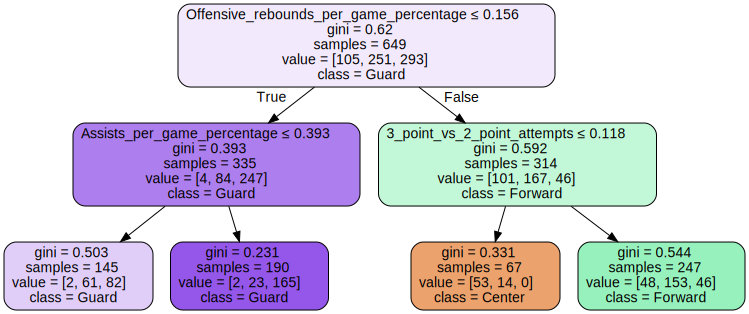

In [ ]:
# create a visualization of tree with graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns,
                                class_names=le.classes_,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:

# create index of correct and incorrect predictions

correct_idx = np.where(y_pred == y_test)[0]
incorrect_idx = np.where(y_pred != y_test)[0]

In [ ]:
# get column number for 'Offensive_rebounds_per_game_percentage' and '3_point_vs_2_point_attempts'

col_idxs = [X_train.columns.get_loc(name) for name in top_features.index]

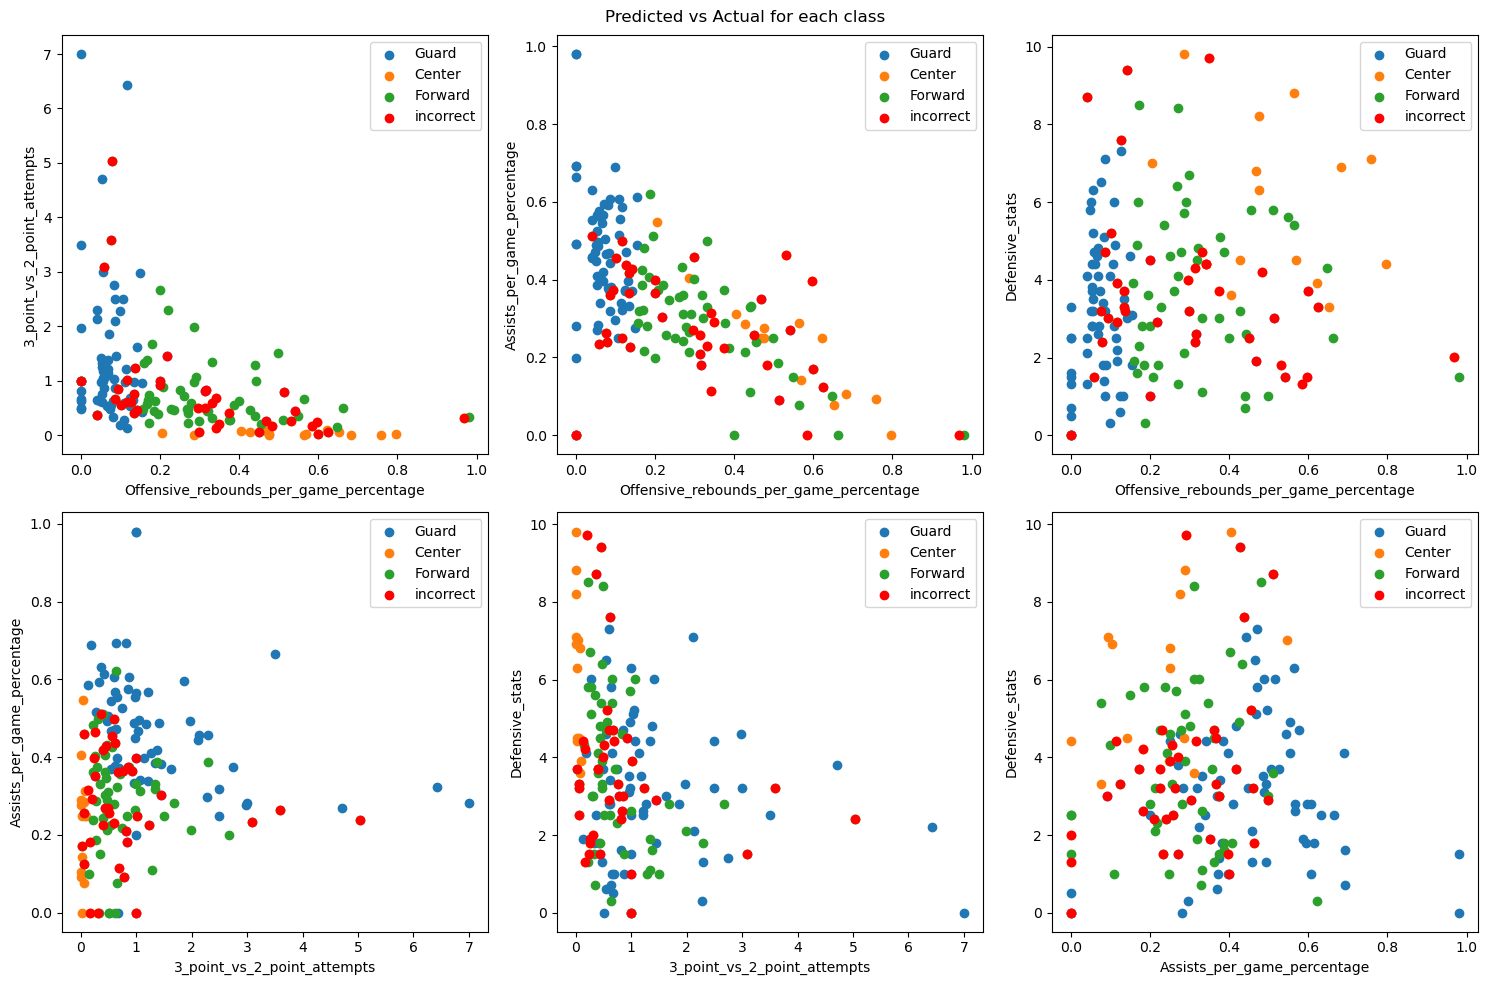

In [ ]:
# plot the pairwise scatterplots for each of the "top predictors" and label the incorrect predictions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for pairidx, pair in enumerate([[34, 27], [34, 33], [34, 28], [27, 33], [27, 28], [33, 28]]):
    for n in y_test.unique():
        idx = np.where(y_test == n)[0]
        axes[pairidx // 3, pairidx % 3].scatter(X_test.iloc[idx, pair[0]], X_test.iloc[idx, pair[1]], label=le.classes_[n])

    axes[pairidx // 3, pairidx % 3].scatter(X_test.iloc[incorrect_idx, pair[0]], X_test.iloc[incorrect_idx, pair[1]], c='r', label='incorrect')
    axes[pairidx // 3, pairidx % 3].set_xlabel(X_train.columns[pair[0]])
    axes[pairidx // 3, pairidx % 3].set_ylabel(X_train.columns[pair[1]])
    axes[pairidx // 3, pairidx % 3].legend()

fig.suptitle('Predicted vs Actual for each class')
fig.tight_layout()


In [ ]:
# get confusion matrix for decision tree classifier

y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[14, 12,  1],
       [ 4, 47, 14],
       [ 0,  8, 63]])

In [ ]:
# use grid search to find best parameters for a random forest classifier with 100 estimators in the ensemble and 5-fold cross validation for hyperparameter tuning
# 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = [
    {'n_estimators': [300], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
    ]

forest_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(forest_clf, param_grid, cv=5,
                            scoring='accuracy', return_train_score=True, verbose=0, n_jobs=-1)

rf_grid.fit(X_train, y_train)
y_pred = rf_grid.predict(X_test)
rf_accuracy = rf_grid.score(X_test, y_test)
rf_auc = roc_auc_score(y_test, rf_grid.predict_proba(X_test), multi_class='ovr')



In [ ]:
# train a gradient boosting classifier

from sklearn.ensemble import HistGradientBoostingClassifier

hist_clf = HistGradientBoostingClassifier(random_state=42, verbose=0, early_stopping=True)
hist_clf.fit(X_train, y_train)
y_pred = hist_clf.predict(X_test)
hist_accuracy = hist_clf.score(X_test, y_test)
hist_auc = roc_auc_score(y_test, hist_clf.predict_proba(X_test), multi_class='ovr')


In [ ]:
# train an xgboost classifier

import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_clf = xgb.XGBClassifier(random_state=42, verbosity=0)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
xgb_accuracy = xgb_clf.score(X_test, y_test)
xgb_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test), multi_class='ovr')


In [ ]:
# create model using lightgbm

import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(random_state=42, verbosity=0, n_jobs=-1)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
lgb_accuracy = lgb_clf.score(X_test, y_test)
lgb_auc = roc_auc_score(y_test, lgb_clf.predict_proba(X_test), multi_class='ovr')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [ ]:
# get accuracy and auc scores for each model on the playoffs dataset

lr_playoffs_accuracy = lr_grid.score(X_playoffs, y_playoffs)
lr_playoffs_auc = roc_auc_score(y_playoffs, lr_grid.predict_proba(X_playoffs), multi_class='ovr')

dt_playoffs_accuracy = clf.score(X_playoffs, y_playoffs)
dt_playoffs_auc = roc_auc_score(y_playoffs, clf.predict_proba(X_playoffs), multi_class='ovr')

rf_playoffs_accuracy = rf_grid.score(X_playoffs, y_playoffs)
rf_playoffs_auc = roc_auc_score(y_playoffs, rf_grid.predict_proba(X_playoffs), multi_class='ovr')

hist_playoffs_accuracy = hist_clf.score(X_playoffs, y_playoffs)
hist_playoffs_auc = roc_auc_score(y_playoffs, hist_clf.predict_proba(X_playoffs), multi_class='ovr')

xgb_playoffs_accuracy = xgb_clf.score(X_playoffs, y_playoffs)
xgb_playoffs_auc = roc_auc_score(y_playoffs, xgb_clf.predict_proba(X_playoffs), multi_class='ovr')

lgb_playoffs_accuracy = lgb_clf.score(X_playoffs, y_playoffs)
lgb_playoffs_auc = roc_auc_score(y_playoffs, lgb_clf.predict_proba(X_playoffs), multi_class='ovr')



,model,accuracy,auc,playoffs_accuracy,playoffs_auc,Playoffs Accuracy,Playoffs AUC
0,Logistic Regression,0.760736,0.896257,0.571429,0.771392,NaN,NaN
1,Decision Tree,0.760736,0.847615,0.571429,0.744341,NaN,NaN
2,Random Forest,0.785276,0.900545,0.658986,0.826075,NaN,NaN
3,Histogram Gradient Boosting,0.766871,0.901453,0.612903,0.808058,NaN,NaN
4,XGBoost,0.803681,0.900976,0.635945,0.822409,NaN,NaN
5,LightGBM,0.766871,0.902758,0.645161,0.823376,NaN,NaN
Logistic Regression,NaN,NaN,NaN,NaN,NaN,0.571,0.771
Decision Tree,NaN,NaN,NaN,NaN,NaN,0.604,0.770
Random Forest,NaN,NaN,NaN,NaN,NaN,0.659,0.826
Gradient Boosting,NaN,NaN,NaN,NaN,NaN,0.613,0.808


In [ ]:
# create a dataframe with the accuracy and auc scores for each model on the regular season dataset formatting decimals to 3 places

model_scores = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
                                'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy, hist_accuracy, xgb_accuracy, lgb_accuracy],
                                'AUC': [lr_auc, dt_auc, rf_auc, hist_auc, xgb_auc, lgb_auc]})
model_scores['Accuracy'] = model_scores['Accuracy'].apply(lambda x: round(x, 3))
model_scores['AUC'] = model_scores['AUC'].apply(lambda x: round(x, 3))

# sort by AUC score in descending order
model_scores.sort_values(by='AUC', ascending=False)



,Model,Accuracy,AUC
5,LightGBM,0.767,0.903
2,Random Forest,0.785,0.901
3,Gradient Boosting,0.767,0.901
4,XGBoost,0.804,0.901
0,Logistic Regression,0.761,0.896
1,Decision Tree,0.742,0.847


In [ ]:
# create a dataframe with the accuracy and auc scores for each model on the playoffs dataset formatting decimals to 3 places

playoffs_scores = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
                                'Accuracy': [lr_playoffs_accuracy, dt_playoffs_accuracy, rf_playoffs_accuracy, hist_playoffs_accuracy, xgb_playoffs_accuracy, lgb_playoffs_accuracy],
                                'AUC': [lr_playoffs_auc, dt_playoffs_auc, rf_playoffs_auc, hist_playoffs_auc, xgb_playoffs_auc, lgb_playoffs_auc]})
playoffs_scores['Accuracy'] = playoffs_scores['Accuracy'].apply(lambda x: round(x, 3))
playoffs_scores['AUC'] = playoffs_scores['AUC'].apply(lambda x: round(x, 3))

# sort by AUC score in descending order
playoffs_scores.sort_values(by='AUC', ascending=False)

,Model,Accuracy,AUC
2,Random Forest,0.659,0.826
5,LightGBM,0.645,0.823
4,XGBoost,0.636,0.822
3,Gradient Boosting,0.613,0.808
0,Logistic Regression,0.571,0.771
1,Decision Tree,0.604,0.770
